# Install packages

In [ ]:
!pip install dwave-system

In [ ]:
!pip install pandas -q

In [ ]:
!pip install boto3

In [ ]:
pip install amazon-braket-sdk

In [ ]:
#pip show amazon-braket-sdk

In [ ]:
pip install dwave-ocean-sdk

In [ ]:
pip install amazon-braket-ocean-plugin

# Code begins here
Source code obatained from [here](https://github.com/dwavesystems/dwave-networkx/blob/main/dwave_networkx/algorithms/tsp.py#L1).

Other references: [Ref1](https://github.com/dwave-training/traveling-salesman/blob/master/hss_exercise.py), [Ref2](https://github.com/aws/amazon-braket-examples/blob/main/examples/quantum_annealing/Dwave_TravelingSalesmanProblem/Dwave_TravelingSalesmanProblem.ipynb).

In [1]:
import itertools

from collections import defaultdict

from dwave_networkx.utils import binary_quadratic_model_sampler

__all__ = ["traveling_salesperson",
           "traveling_salesperson_qubo",
           "traveling_salesman",
           "traveling_salesman_qubo",
           "is_hamiltonian_path",
           ]


@binary_quadratic_model_sampler(1)
def traveling_salesperson(G, sampler=None, lagrange=None, weight='weight',
                          start=None, **sampler_args):
    """Returns an approximate minimum traveling salesperson route.
    Defines a QUBO with ground states corresponding to the
    minimum routes and uses the sampler to sample
    from it.
    A route is a cycle in the graph that reaches each node exactly once.
    A minimum route is a route with the smallest total edge weight.
    Parameters
    ----------
    G : NetworkX graph
        The graph on which to find a minimum traveling salesperson route.
        This should be a complete graph with non-zero weights on every edge.
    sampler :
        A binary quadratic model sampler. A sampler is a process that
        samples from low energy states in models defined by an Ising
        equation or a Quadratic Unconstrained Binary Optimization
        Problem (QUBO). A sampler is expected to have a 'sample_qubo'
        and 'sample_ising' method. A sampler is expected to return an
        iterable of samples, in order of increasing energy. If no
        sampler is provided, one must be provided using the
        `set_default_sampler` function.
    lagrange : number, optional (default None)
        Lagrange parameter to weight constraints (visit every city once)
        versus objective (shortest distance route).
    weight : optional (default 'weight')
        The name of the edge attribute containing the weight.
    start : node, optional
        If provided, the route will begin at `start`.
    sampler_args :
        Additional keyword parameters are passed to the sampler.
    Returns
    -------
    route : list
       List of nodes in order to be visited on a route
    Examples
    --------
    >>> import dimod
    ...
    >>> G = nx.Graph()
    >>> G.add_weighted_edges_from({(0, 1, .1), (0, 2, .5), (0, 3, .1), (1, 2, .1),
    ...                            (1, 3, .5), (2, 3, .1)})
    >>> dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0) # doctest: +SKIP
    [0, 1, 2, 3]
    Notes
    -----
    Samplers by their nature may not return the optimal solution. This
    function does not attempt to confirm the quality of the returned
    sample.
    """
    # Get a QUBO representation of the problem
    Q = traveling_salesperson_qubo(G, lagrange, weight)

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args)

    sample = response.first.sample

    route = [None]*len(G)
    for (city, time), val in sample.items():
        if val:
            route[time] = city

    if start is not None and route[0] != start:
        # rotate to put the start in front
        idx = route.index(start)
        route = route[idx:] + route[:idx]

    return route


traveling_salesman = traveling_salesperson


def traveling_salesperson_qubo(G, lagrange=None, weight='weight', missing_edge_weight=None):
    """Return the QUBO with ground states corresponding to a minimum TSP route.
    If :math:`|G|` is the number of nodes in the graph, the resulting qubo will have:
    * :math:`|G|^2` variables/nodes
    * :math:`2 |G|^2 (|G| - 1)` interactions/edges
    Parameters
    ----------
    G : NetworkX graph
        A complete graph in which each edge has a attribute giving its weight.
    lagrange : number, optional (default None)
        Lagrange parameter to weight constraints (no edges within set)
        versus objective (largest set possible).
    weight : optional (default 'weight')
        The name of the edge attribute containing the weight.
    
    missing_edge_weight : number, optional (default None)
        For bi-directional graphs, the weight given to missing edges.
        If None is given (the default), missing edges will be set to
        the sum of all weights.
    Returns
    -------
    QUBO : dict
       The QUBO with ground states corresponding to a minimum travelling
       salesperson route. The QUBO variables are labelled `(c, t)` where `c`
       is a node in `G` and `t` is the time index. For instance, if `('a', 0)`
       is 1 in the ground state, that means the node 'a' is visted first.
    """
    N = G.number_of_nodes()

    if lagrange is None:
        # If no lagrange parameter provided, set to 'average' tour length.
        # Usually a good estimate for a lagrange parameter is between 75-150%
        # of the objective function value, so we come up with an estimate for 
        # tour length and use that.
        if G.number_of_edges()>0:
            lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
        else:
            lagrange = 2
    
    # calculate default missing_edge_weight if required
    if missing_edge_weight is None:
        # networkx method to calculate sum of all weights
        missing_edge_weight = G.size(weight=weight)

    # some input checking
    if N in (1, 2):
        msg = "graph must have at least 3 nodes or be empty"
        raise ValueError(msg)

    # Creating the QUBO
    Q = defaultdict(float)

    # Constraint that each row has exactly one 1
    for node in G:
        for pos_1 in range(N):
            Q[((node, pos_1), (node, pos_1))] -= lagrange
            for pos_2 in range(pos_1+1, N):
                Q[((node, pos_1), (node, pos_2))] += 2.0*lagrange

    # Constraint that each col has exactly one 1
    for pos in range(N):
        for node_1 in G:
            Q[((node_1, pos), (node_1, pos))] -= lagrange
            for node_2 in set(G)-{node_1}:
                # QUBO coefficient is 2*lagrange, but we are placing this value 
                # above *and* below the diagonal, so we put half in each position.
                Q[((node_1, pos), (node_2, pos))] += lagrange

    # Objective that minimizes distance
    for u, v in itertools.combinations(G.nodes, 2):
        for pos in range(N):
            nextpos = (pos + 1) % N

            # going from u -> v
            try:
                value = G[u][v][weight]
            except KeyError:
                value = missing_edge_weight

            Q[((u, pos), (v, nextpos))] += value

            # going from v -> u
            try:
                value = G[v][u][weight]
            except KeyError:
                value = missing_edge_weight

            Q[((v, pos), (u, nextpos))] += value

    return Q


traveling_salesman_qubo = traveling_salesperson_qubo


def is_hamiltonian_path(G, route):
    """Determines whether the given list forms a valid TSP route.
    A travelling salesperson route must visit each city exactly once.
    Parameters
    ----------
    G : NetworkX graph
        The graph on which to check the route.
    route : list
        List of nodes in the order that they are visited.
    Returns
    -------
    is_valid : bool
        True if route forms a valid travelling salesperson route.
    """

    return (set(route) == set(G))

{(0, 1): Text(0.007101753125483334, -0.07364023887696097, '2.7'),
 (0, 2): Text(-0.08485073588930797, 0.8363519577228222, '3.7'),
 (0, 3): Text(-0.9484954149858719, -0.04535257093554279, '7.2'),
 (0, 4): Text(-0.45245034287385333, 0.3151812852558069, '8.4'),
 (1, 2): Text(0.9080475109852086, 0.07435143006844436, '4.5'),
 (1, 3): Text(0.0444028318886448, -0.8073530985899207, '3.7'),
 (1, 4): Text(0.5404479040006633, -0.446819242398571, '9.4'),
 (2, 3): Text(-0.047549657126146505, 0.10263909800986254, '3.5'),
 (2, 4): Text(0.44849541498587203, 0.46317295420121224, '5.4'),
 (3, 4): Text(-0.41514926411069186, -0.41853157445715283, '6.2')}

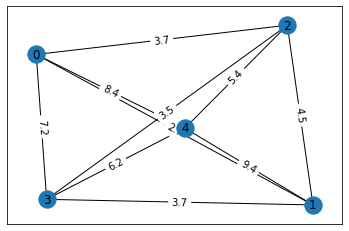

In [2]:
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import pandas as pd
import itertools

%matplotlib inline
from random import *
data = pd.read_csv('dataset.txt', sep ='\s+', header=None)
# Place --  Node Number
# Fort  --  0
# Churchgate --  1
# Khetwadi  --  2
# Malabar Hills  --  3
# Parel  --  4
num_cities = data.shape[0]
G = nx.from_pandas_adjacency(data)
pos = nx.spring_layout(G, seed = randint(1,100))
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight')
# plt.axis('off')
nx.draw_networkx(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)

## Solution with Simulated Annealing

In [4]:
route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
print('Route found with simulated annealing:', route)

total_dist = 0
for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    total_dist += dist
    
return_distance = data[route[0]][route[-1]]
print('Total distance, including return to initial node:', return_distance+total_dist, 'km')

Route found with simulated annealing: [0, 1, 3, 4, 2]
Total distance, including return to initial node: 21.7 km


## Solution on D-Wave Quantum Annealer

In [5]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

##   Put Amazon-Braket account details here!!

sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
num_shots = 1000
route = traveling_salesperson(G, sampler, lagrange=lagrange,
                              start=0, num_reads=num_shots, answer_mode="histogram")
print('Route found with D-Wave:', route)
total_dist = 0
for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    total_dist += dist
    
return_distance = data[route[0]][route[-1]]
print('Total distance from D-Wave quantum annealer, including return to initial node:',
      return_distance+total_dist)

NoRegionError: You must specify a region.